In [11]:
# this file is for running the line-fitting models and plot the best-fitting results 
import numpy as np
from astropy.io import fits
import os, sys
# from veremisfitting.line_fitting_exec import *
# from veremisfitting.line_fitting_model import *
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models,fitting
from scipy import interpolate

%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd

import astropy.io.fits as pyfits
import astropy.units as u

import sep
import glob
import grizli
from grizli import utils
print(f'grizli version: {grizli.__version__}')

import msaexp
import msaexp.spectrum
print(f'msaexp version: {msaexp.__version__}')

from astropy.table import Table
import astropy.units as u
from scipy.interpolate import InterpolatedUnivariateSpline
from matplotlib.gridspec import GridSpec
from astropy.cosmology import FlatLambdaCDM
import matplotlib.ticker as ticker
cosmo = FlatLambdaCDM(70 * (u.km/u.s/u.Mpc), 0.3)

import astropy.units as u
import astropy.constants as c
import matplotlib.cm as cm
cmap = cm.get_cmap('rainbow')
plt.style.use('/Users/zijianzhang/Astro_Data/paper.mplstyle')


BASE_URL = 'https://s3.amazonaws.com/msaexp-nirspec/extractions/'
PATH_TO_FILE = BASE_URL + '{root}/{file}'
# define the absolute path of the current working directory
current_direc = os.getcwd() 

def read_results_from_txt(filename):
    """
    Read flux, EW, FWHM results with errors, Gaussian parameters, and Chi-squared values from a text file.

    Parameters:
    - filename: Path to the input text file.
    
    Returns:
    - A dictionary containing all the extracted parameters, including Gaussian parameters and their errors.
    """
    results = {}

    with open(filename, 'r') as f:
        lines = f.readlines()

    # Extract source ID
    results['source_id'] = lines[0].split(":")[1].strip()

    # Find the number of Gaussian components
    for line in lines:
        if line.startswith("Number of Gaussian Components"):
            results['num_gaussians'] = int(line.split(":")[1].strip())
            break
    
    # Extract Gaussian components parameters and errors
    gaussians = []
    current_gaussian = None
    for line in lines:
        if line.startswith("Gaussian"):
            if current_gaussian is not None:
                gaussians.append(current_gaussian)
            current_gaussian = {}
        if line.startswith("  Amplitude"):
            current_gaussian['Amplitude'] = float(line.split('=')[1].split('±')[0].strip())
            current_gaussian['Amplitude_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("  Mean (Velocity)"):
            current_gaussian['Mean'] = float(line.split('=')[1].split('±')[0].strip())
            current_gaussian['Mean_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("  Stddev (Width)"):
            current_gaussian['Stddev'] = float(line.split('=')[1].split('±')[0].strip())
            current_gaussian['Stddev_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("-" * 40):  # End of a Gaussian block
            if current_gaussian is not None:
                gaussians.append(current_gaussian)
                current_gaussian = None

    # remove empty gaussians
    gaussians = [g for g in gaussians if g]
    results['gaussians'] = gaussians
    

    # Extract component results (Flux, EW, FWHM)
    components = []
    current_component = None
    for line in lines:
        if line.startswith("Gaussian"):
            if current_component is not None:
                components.append(current_component)
            current_component = {}
        if line.startswith("  Flux"):
            current_component['Flux'] = float(line.split('=')[1].split('±')[0].strip())
            current_component['Flux_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("  EW"):
            current_component['EW'] = float(line.split('=')[1].split('±')[0].strip())
            current_component['EW_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("  FWHM"):
            current_component['FWHM'] = float(line.split('=')[1].split('±')[0].strip())
            current_component['FWHM_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("  Luminosity"): 
            current_component['Luminosity'] = float(line.split('=')[1].split('±')[0].strip())
            current_component['Luminosity_Error'] = float(line.split('±')[1].strip().split()[0])
        elif line.startswith("-" * 40):  # End of a component block
            if current_component is not None:
                components.append(current_component)
                current_component = None

    # remove empty components
    components = [c for c in components if c]
    results['components'] = components

    # Extract Chi-squared and Reduced Chi-squared values
    for line in lines:
        if line.startswith("Chi-squared"):
            results['chi2'] = float(line.split(":")[1].strip())
        elif line.startswith("Reduced Chi-squared"):
            results['reduced_chi2'] = float(line.split(":")[1].strip())

    return results

def read_filter_data(filename):
    data = np.loadtxt(filename, skiprows=1)
    wavelength = data[:, 0]
    throughput = data[:, 1]
    return wavelength, throughput

def lam_mean(lam, trans):
    if not len(lam) == len(trans):
        return 'wrong'
    sum1 = 0; sum2 = 0
    for i in range(len(lam)-1):
        sum1 += lam[i] * trans[i] * (lam[i+1] - lam[i])
        sum2 += trans[i] * (lam[i+1] - lam[i])
    return sum1/sum2

def clc_lam_pivot(wave, trans):
    f1 = InterpolatedUnivariateSpline(wave, trans, k=1) 
    f2 = InterpolatedUnivariateSpline(wave, trans/wave**2, k=1) 
    lam_pivot =  (f1.integral(min(wave), max(wave)) / f2.integral(min(wave), max(wave)))**0.5
    return lam_pivot


Duplicate key in file '/Users/zijianzhang/Astro_Data/paper.mplstyle', line 23 ('axes.linewidth : 1.5')


grizli version: 1.12.9
msaexp version: 0.9.2


In [12]:
# 使用样条插值计算 rest-frame NUV 和 FUV（假设 NUV 是 2310 Å，FUV 是 1530 Å）
rest_NUV = 2310  # NUV 波长 (单位: Å)
rest_FUV = 1530  # FUV 波长 (单位: Å)   

Hz_NUV = (const.c / (rest_NUV * u.AA)).to(u.Hz)
Hz_FUV = (const.c / (rest_FUV * u.AA)).to(u.Hz)
# 计算 NUV 和 FUV 的光度（erg/s/Hz）
F_NUV = spline(rest_NUV)*u.erg / (u.s * u.Hz * u.cm**2)
F_FUV = spline(rest_FUV)*u.erg / (u.s * u.Hz * u.cm**2)    
lumi_dist = cosmo.luminosity_distance(redshift).to(u.cm)
L_NUV = (4 * np.pi * lumi_dist**2 * F_NUV * Hz_NUV).to(u.erg/u.s).value
L_FUV = (4 * np.pi * lumi_dist**2 * F_FUV * Hz_FUV).to(u.erg/u.s).value
# 显示结果
# print(f"Slope: {slope:.3e}, Intercept: {intercept:.3e}")
print(f"Rest-frame NUV flux: {L_NUV:.3e} erg/s")
print(f"Rest-frame FUV flux: {L_FUV:.3e} erg/s") 

NameError: name 'const' is not defined

In [13]:
lrd_spec_info = Table.read('/Users/zijianzhang/Astro_Data/LRD_SPEC/narrow_Ha_result_lsf_z2/LRD_spectral_catalog.csv')
source_id = lrd_spec_info['source_id']

jades_gal_info = Table.read('/Users/zijianzhang/Astro_Data/LRD_SPEC/jades_galaxy/LRD_spectral_catalog.csv')
jades_source_uid = jades_gal_info['source_id']
jades_DJA_cat = Table.read('/Users/zijianzhang/Astro_Data/LRD_SPEC/catalog/jades_galaxies_sfr_withspecphot_DJA.csv')
jades_NIRspec_ID = []
for i in range(len(jades_source_uid)):
    thisuid = jades_source_uid[i]
    index = np.where(jades_DJA_cat['uid'] == thisuid)[0][0]
    jades_NIRspec_ID.append(jades_DJA_cat['NIRSpec ID'][index])

nakajimi_gal_info = Table.read('/Users/zijianzhang/Astro_Data/LRD_SPEC/nakajima_line_fit/LRD_spectral_catalog.csv')
nakajimi_source_uid = nakajimi_gal_info['source_id']


In [2]:
def get_UV_luminosity(ID, results_path, fig_save_path):
# lrd_cigale_path = '/Users/zijianzhang/Astro_Data/LRD_SPEC/cigale_sed_fitting/out/'
# results_path = lrd_cigale_path
# fig_save_path = '/Users/zijianzhang/Astro_Data/LRD_SPEC/cigale_sed_fitting/LRD_UV_luminosity/'
# for oio in range(1):
    f = fits.open(results_path + '/%d_best_model.fits'%ID)
    z = float(f[1].header['universe.redshift'])
    
    NUV_wave_obs = 0.2310*(1+z)*u.um
    FUV_wave_obs = 0.1530*(1+z)*u.um
    NUV_freq_obs = (c.c / NUV_wave_obs).to(u.Hz)
    FUV_freq_obs = (c.c / FUV_wave_obs).to(u.Hz)
    DL = cosmo.luminosity_distance(z)
    
    data_mod = f[1].data
    wave_mod = data_mod['wavelength']*1e-3# micro meter
    flux_mod = data_mod['Fnu']
    f_obs = fits.open(results_path + '/observations.fits')
    data_obs = f_obs[1].data
    f_mod_band = fits.open(results_path + '/results.fits')
    

    data_mod_band = f_mod_band[1].data
    q = np.where(data_mod_band['id']==ID)[0][0]
    EBV = data_mod_band[q]['bayes.attenuation.E_BV_lines']
    sedsfr10 = data_mod_band[q]['best.sfh.sfr10Myrs']
    sedsfr100 = data_mod_band[q]['best.sfh.sfr100Myrs']
    

    band_lam = []; band_flux = []
    data_obs_bands = data_obs.names[2::2]  #data_obs.names[2:25]
    obsy = np.array(list(data_obs[q][2::2]))
    obsyerr = np.array(list(data_obs[q][3::2]))
    data_obs_bands = np.array(data_obs_bands)
    mask = obsyerr > 0



    obsy = np.array(list(data_obs[q][2::2]))
    obsyerr = np.array(list(data_obs[q][3::2]))
    data_obs_bands = np.array(data_obs_bands)
    mask = obsyerr > 0
    data_obs_bands = data_obs_bands[mask]
    colors = [cmap(i) for i in np.linspace(0, 1, len(data_obs_bands))]
    for j in range(len(data_obs_bands)):
        band = data_obs_bands[j]
        band_tran = band.split('.')[-1]
        file = '/Users/zijianzhang/Astro_Data/LRD_SPEC/nircam_throughputs/mean_throughputs/' + band_tran.upper() + '_throughput.txt'
        wave, trans = read_filter_data(file)
        wave = np.array(wave)*1e-4; trans = np.array(trans)
        wave_pivot = clc_lam_pivot(wave, trans)
        band_lam.append(wave_pivot)
        band_flux.append(data_mod_band['best.'+band][q] )



    colors = [cmap(i) for i in np.linspace(0, 1, len(data_obs_bands))]
    data_tot = data_mod['stellar.old'] + data_mod['stellar.young'] + data_mod['nebular.emission_old'] + data_mod['nebular.emission_young']
    # data_AGN = data_mod['agn.SKIRTOR2016_torus'] + data_mod['agn.SKIRTOR2016_polar_dust'] + data_mod['agn.SKIRTOR2016_disk']
    attenuated_stellar = data_mod['stellar.young'] + data_mod['attenuation.stellar.young'] + data_mod['nebular.absorption_young'] + data_mod['stellar.old'] + data_mod['attenuation.stellar.old'] + data_mod['nebular.absorption_old']
    data_tot = (data_tot * u.W/u.nm / DL**2 * (wave_mod*u.um)**2 / c.c).to(u.mJy) / 13.267335
    # data_AGN = (data_AGN * u.W/u.nm / DL**2 * (wave_mod*u.um)**2 / c.c).to(u.mJy) / 13.267335
    attenuated_stellar = (attenuated_stellar * u.W/u.nm / DL**2 * (wave_mod*u.um)**2 / c.c).to(u.mJy) / 13.267335


    plt.scatter( np.log10(band_lam), band_flux, color = 'red', s = 30, zorder=9, label='Model')
    # plt.errorbar(np.log10(band_lam), obsy[mask], yerr = obsyerr[mask], 
    #                  ms=8, color = 'purple', fmt = 'o', markerfacecolor=(0, 0, 0, 0),
    #                  markeredgecolor='purple', zorder=10, label='Observed')
    plt.plot(np.log10(wave_mod),data_tot, color = '#1075F8', lw = 1.3, zorder=5 , ls = '--', label = 'Unattenuated stellar and nebular')
    plt.plot(np.log10(wave_mod),attenuated_stellar, color = '#FFD707', lw = 1.3, zorder=5, label = 'Attenuated stellar')
    # plt.plot(np.log10(wave_mod),data_AGN, color = '#FFB677', lw = 1.3, zorder=5, label = 'AGN emission')
    plt.plot(np.log10(wave_mod), flux_mod, color = 'k', lw = 1.3, zorder=6, label='Model Spectrum')
    plt.axvline(np.log10(NUV_wave_obs.value), color = 'k', lw = 1.3, ls = '--')
    plt.axvline(np.log10(FUV_wave_obs.value), color = 'k', lw = 1.3, ls = '--')
    # plt.xlim(np.log10(0.7), np.log10(5.2)); plt.ylim(ylim)
    plt.ylabel(r'F$_{\nu}$ (mJy)')
    plt.legend(loc=4, bbox_to_anchor=(1, 0.1), fontsize = 6, ncol=2)
    plt.yscale('log')
    plt.xlim(np.log10(0.1), np.log10(5.2))
    plt.savefig(fig_save_path + 'UV_luminosity_%d.png'%ID, dpi=300, bbox_inches='tight')
    plt.close()


    spline_att = interpolate.CubicSpline(wave_mod, attenuated_stellar)  
    spline_unatt = interpolate.CubicSpline(wave_mod, data_tot)
    # 计算 NUV 和 FUV 的光度（erg/s/Hz）
    Fv_NUV_att = spline_att(NUV_wave_obs)*u.mJy
    Fv_FUV_att = spline_att(FUV_wave_obs)*u.mJy
    Fv_NUV_unatt = spline_unatt(NUV_wave_obs)*u.mJy
    Fv_FUV_unatt = spline_unatt(FUV_wave_obs)*u.mJy
    L_NUV_att = (4 * np.pi * DL**2 * Fv_NUV_att * NUV_freq_obs).to(u.erg/u.s).value
    L_FUV_att = (4 * np.pi * DL**2 * Fv_FUV_att * FUV_freq_obs).to(u.erg/u.s).value
    L_NUV_unatt = (4 * np.pi * DL**2 * Fv_NUV_unatt * NUV_freq_obs).to(u.erg/u.s).value
    L_FUV_unatt = (4 * np.pi * DL**2 * Fv_FUV_unatt * FUV_freq_obs).to(u.erg/u.s).value

    return L_NUV_att, L_FUV_att, L_NUV_unatt, L_FUV_unatt, EBV, sedsfr10, sedsfr100
    # 显示结果
    # print(f"Rest-frame NUV flux (attenuated): {L_NUV_att:.3e} erg/s")
    # print(f"Rest-frame FUV flux (attenuated): {L_FUV_att:.3e} erg/s")
    # print(f"Rest-frame NUV flux (unattenuated): {L_NUV_unatt:.3e} erg/s")
    # print(f"Rest-frame FUV flux (unattenuated): {L_FUV_unatt:.3e} erg/s")

In [3]:
lrd_cigale_path = '/Users/zijianzhang/Astro_Data/LRD_SPEC/cigale_sed_fitting/out/'
fig_save_path = '/Users/zijianzhang/Astro_Data/LRD_SPEC/cigale_sed_fitting/LRD_UV_luminosity/'

L_NUV_att_list = []
L_FUV_att_list = []
L_NUV_unatt_list = []
L_FUV_unatt_list = []
EBV_list = []
sedsfr10_list = []
sedsfr100_list = []

err_ID = []
for srcid in source_id:
    try:
        L_NUV_att, L_FUV_att, L_NUV_unatt, L_FUV_unatt, EBV, sedsfr10, sedsfr100 = get_UV_luminosity(srcid, lrd_cigale_path, fig_save_path)
    except:
        L_NUV_att = np.nan
        L_FUV_att = np.nan
        L_NUV_unatt = np.nan
        L_FUV_unatt = np.nan
        EBV = np.nan
        sedsfr10 = np.nan
        sedsfr100 = np.nan
        err_ID.append(srcid)
    L_NUV_att_list.append(L_NUV_att)
    L_FUV_att_list.append(L_FUV_att)
    L_NUV_unatt_list.append(L_NUV_unatt)
    L_FUV_unatt_list.append(L_FUV_unatt)
    sedsfr10_list.append(sedsfr10)
    sedsfr100_list.append(sedsfr100)
    EBV_list.append(EBV)
lrd_spec_info['L_NUV_att'] = L_NUV_att_list
lrd_spec_info['L_FUV_att'] = L_FUV_att_list
lrd_spec_info['L_NUV_unatt'] = L_NUV_unatt_list
lrd_spec_info['L_FUV_unatt'] = L_FUV_unatt_list
lrd_spec_info['EBV'] = EBV_list
lrd_spec_info['sedsfr10'] = sedsfr10_list
lrd_spec_info['sedsfr100'] = sedsfr100_list

NameError: name 'source_id' is not defined

In [16]:
lrd_cigale_path = '/Users/zijianzhang/Astro_Data/LRD_SPEC/cigale_sed_fitting/out_jadegal/'
fig_save_path = '/Users/zijianzhang/Astro_Data/LRD_SPEC/cigale_sed_fitting/jadesgal_UV_luminosity/'
os.makedirs(fig_save_path, exist_ok=True)

L_NUV_att_list = []
L_FUV_att_list = []
L_NUV_unatt_list = []
L_FUV_unatt_list = []
EBV_list = []
sedsfr10_list = []
sedsfr100_list = []
err_ID = []
for srcid in jades_NIRspec_ID:
    try:
        L_NUV_att, L_FUV_att, L_NUV_unatt, L_FUV_unatt, EBV, sedsfr10, sedsfr100 = get_UV_luminosity(srcid, lrd_cigale_path, fig_save_path)
    except:
        L_NUV_att = np.nan
        L_FUV_att = np.nan
        L_NUV_unatt = np.nan
        L_FUV_unatt = np.nan
        EBV = np.nan
        sedsfr10 = np.nan
        sedsfr100 = np.nan
        err_ID.append(srcid)
    L_NUV_att_list.append(L_NUV_att)
    L_FUV_att_list.append(L_FUV_att)
    L_NUV_unatt_list.append(L_NUV_unatt)
    L_FUV_unatt_list.append(L_FUV_unatt)
    sedsfr10_list.append(sedsfr10)
    sedsfr100_list.append(sedsfr100)
    EBV_list.append(EBV)
jades_gal_info['L_NUV_att'] = L_NUV_att_list
jades_gal_info['L_FUV_att'] = L_FUV_att_list
jades_gal_info['L_NUV_unatt'] = L_NUV_unatt_list
jades_gal_info['L_FUV_unatt'] = L_FUV_unatt_list
jades_gal_info['EBV'] = EBV_list
jades_gal_info['sedsfr10'] = sedsfr10_list
jades_gal_info['sedsfr100'] = sedsfr100_list

In [17]:
lrd_cigale_path = '/Users/zijianzhang/Astro_Data/LRD_SPEC/cigale_sed_fitting/out_nakajima_gal/'
fig_save_path = '/Users/zijianzhang/Astro_Data/LRD_SPEC/cigale_sed_fitting/nakajimagal_UV_luminosity/'
os.makedirs(fig_save_path, exist_ok=True)

L_NUV_att_list = []
L_FUV_att_list = []
L_NUV_unatt_list = []
L_FUV_unatt_list = []
EBV_list = []
sedsfr10_list = []
sedsfr100_list = []
err_ID = []
for srcid in nakajimi_source_uid:
    try:
        L_NUV_att, L_FUV_att, L_NUV_unatt, L_FUV_unatt, EBV, sedsfr10, sedsfr100 = get_UV_luminosity(srcid, lrd_cigale_path, fig_save_path)
    except:
        L_NUV_att = np.nan
        L_FUV_att = np.nan
        L_NUV_unatt = np.nan
        L_FUV_unatt = np.nan
        EBV = np.nan
        sedsfr10 = np.nan
        sedsfr100 = np.nan
        err_ID.append(srcid)
    L_NUV_att_list.append(L_NUV_att)
    L_FUV_att_list.append(L_FUV_att)
    L_NUV_unatt_list.append(L_NUV_unatt)
    L_FUV_unatt_list.append(L_FUV_unatt)
    EBV_list.append(EBV)
    sedsfr10_list.append(sedsfr10)
    sedsfr100_list.append(sedsfr100)
nakajimi_gal_info['L_NUV_att'] = L_NUV_att_list
nakajimi_gal_info['L_FUV_att'] = L_FUV_att_list
nakajimi_gal_info['L_NUV_unatt'] = L_NUV_unatt_list
nakajimi_gal_info['L_FUV_unatt'] = L_FUV_unatt_list
nakajimi_gal_info['EBV'] = EBV_list
nakajimi_gal_info['sedsfr10'] = sedsfr10_list
nakajimi_gal_info['sedsfr100'] = sedsfr100_list

In [19]:
narrowuidlist = [ 8219, 12329,  16321, 20547,22015]
narrow_Ha_mask = np.array([i in narrowuidlist for i in source_id.value])

In [6]:
lrd_spec_info

NameError: name 'lrd_spec_info' is not defined

In [7]:
jades_gal_info

NameError: name 'jades_gal_info' is not defined

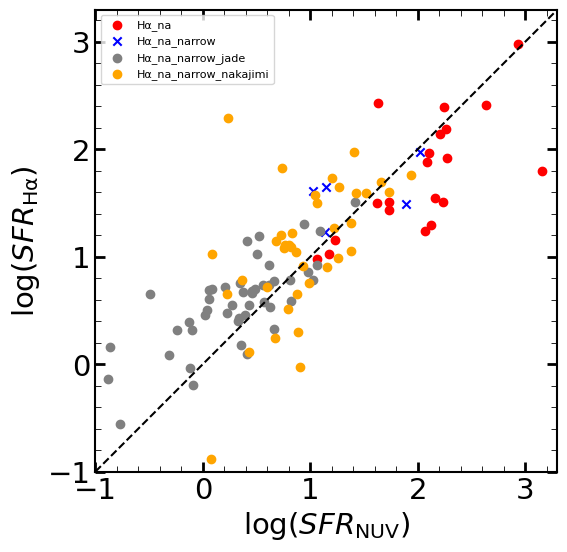

In [20]:
# change to good plt style
# plt.style.use('seaborn-v0_8-colorblind')


lrd_AV = lrd_spec_info['EBV'] * 3.16
jadegal_AV = jades_gal_info['EBV'] * 3.16
nakajimigal_AV = nakajimi_gal_info['EBV'] * 3.16

Ha_br_lumi, Ha_br_lumi_err = lrd_spec_info['Ha_Luminosity_broad'],lrd_spec_info['Ha_Luminosity_err_broad']
Ha_na_lumi, Ha_na_lumi_err = lrd_spec_info['Ha_Luminosity_narrow'], lrd_spec_info['Ha_Luminosity_err_narrow']
Ha1_na_lumi, Ha1_na_lumi_err = lrd_spec_info['Ha_Luminosity_narrow_Ha1'], lrd_spec_info['Ha_Luminosity_err_narrow_Ha1']
Ha1_na_lumi_jade, Ha1_na_lumi_err_jade = jades_gal_info['Ha_Luminosity'], jades_gal_info['Ha_Luminosity_err']
Ha1_na_lumi_nakajimi, Ha1_na_lumi_err_nakajimi = nakajimi_gal_info['Ha_Luminosity'], nakajimi_gal_info['Ha_Luminosity_err']

Ha_br_lumi, Ha_br_lumi_err = lrd_spec_info['Ha_Luminosity_broad']*10**(0.4*lrd_AV),lrd_spec_info['Ha_Luminosity_err_broad']*10**(0.4*lrd_AV)
Ha_na_lumi, Ha_na_lumi_err = lrd_spec_info['Ha_Luminosity_narrow']*10**(0.4*lrd_AV), lrd_spec_info['Ha_Luminosity_err_narrow']*10**(0.4*lrd_AV)
Ha1_na_lumi, Ha1_na_lumi_err = lrd_spec_info['Ha_Luminosity_narrow_Ha1']*10**(0.4*lrd_AV), lrd_spec_info['Ha_Luminosity_err_narrow_Ha1']*10**(0.4*lrd_AV)
Ha1_na_lumi_jade, Ha1_na_lumi_err_jade = jades_gal_info['Ha_Luminosity']*10**(0.4*jadegal_AV), jades_gal_info['Ha_Luminosity_err']*10**(0.4*jadegal_AV)
Ha1_na_lumi_nakajimi, Ha1_na_lumi_err_nakajimi = nakajimi_gal_info['Ha_Luminosity']*10**(0.4*nakajimigal_AV), nakajimi_gal_info['Ha_Luminosity_err']*10**(0.4*nakajimigal_AV)

# L_NUV = lrd_spec_info['L_NUV_att']
# L_FUV = lrd_spec_info['L_FUV_att']
# L_NUV_jade, L_FUV_jade = jades_gal_info['L_NUV_att'], jades_gal_info['L_FUV_att']
# L_NUV_nakajimi, L_FUV_nakajimi = nakajimi_gal_info['L_NUV_att'], nakajimi_gal_info['L_FUV_att']

L_NUV = lrd_spec_info['L_NUV_unatt']
L_FUV = lrd_spec_info['L_FUV_unatt']
L_NUV_jade, L_FUV_jade = jades_gal_info['L_NUV_unatt'],jades_gal_info['L_FUV_unatt']
L_NUV_nakajimi, L_FUV_nakajimi = nakajimi_gal_info['L_NUV_unatt'], nakajimi_gal_info['L_FUV_unatt']


logsfr_NUV = np.log10(L_NUV) - 43.17
logsfr_FUV = np.log10(L_FUV) - 43.35
logsfr_Ha_nr = np.log10(Ha_na_lumi) - 41.27
logsfr_Ha_nr_err = Ha_na_lumi_err / Ha_na_lumi / np.log(10)
logsfr_Ha_br = np.log10(Ha_br_lumi) - 41.27
logsfr_Ha_br_err = Ha_br_lumi_err / Ha_br_lumi / np.log(10)
logsfr_Ha_all = np.log10(Ha_na_lumi + Ha_br_lumi) - 41.27
logsfr_Ha_all_err = np.sqrt(Ha_na_lumi_err**2 + Ha_br_lumi_err**2) / (Ha_na_lumi + Ha_br_lumi) / np.log(10)
logsfr_Ha1_na = np.log10(Ha1_na_lumi) - 41.27
logsfr_Ha1_na_err = Ha1_na_lumi_err / Ha1_na_lumi / np.log(10)

logsfr_NUV_jade = np.log10(L_NUV_jade) - 43.17
logsfr_FUV_jade = np.log10(L_FUV_jade) - 43.35
logsfr_Ha1_na_jade = np.log10(Ha1_na_lumi_jade) - 41.27
logsfr_Ha1_na_err_jade = Ha1_na_lumi_err_jade / Ha1_na_lumi_jade / np.log(10)

logsfr_NUV_nakajimi = np.log10(L_NUV_nakajimi) - 43.17
logsfr_FUV_nakajimi = np.log10(L_FUV_nakajimi) - 43.35
logsfr_Ha1_na_nakajimi = np.log10(Ha1_na_lumi_nakajimi) - 41.27
logsfr_Ha1_na_err_nakajimi = Ha1_na_lumi_err_nakajimi / Ha1_na_lumi_nakajimi / np.log(10)

plt.figure(figsize=(6, 6))
plt.gca().set_aspect('equal')
# plt.errorbar(logsfr_NUV, logsfr_Ha_nr, xerr=None, yerr=Ha_na_lumi_err, fmt='o', label='Hα_br')
plt.scatter(logsfr_NUV[~narrow_Ha_mask], logsfr_Ha_nr[~narrow_Ha_mask], c='r', label='Hα_na')
# plt.scatter(logsfr_NUV[narrow_Ha_mask], logsfr_Ha_nr[narrow_Ha_mask], c='blue', label='Hα_na_narrow', marker='x')
plt.scatter(logsfr_NUV[narrow_Ha_mask], logsfr_Ha1_na[narrow_Ha_mask], c='blue', label='Hα_na_narrow', marker='x')
plt.scatter(logsfr_NUV_jade, logsfr_Ha1_na_jade, label='Hα_na_narrow_jade', marker='o', color = 'gray')
plt.scatter(logsfr_NUV_nakajimi, logsfr_Ha1_na_nakajimi, label='Hα_na_narrow_nakajimi', marker='o', color = 'orange')

# plt.errorbar(logsfr_NUV[~narrow_Ha_mask], logsfr_Ha_br[~narrow_Ha_mask], xerr=None, yerr=Ha_br_lumi_err[~narrow_Ha_mask], fmt='o', label='Hα_br')
# plt.errorbar(logsfr_NUV[narrow_Ha_mask], logsfr_Ha_br[narrow_Ha_mask], xerr=None, yerr=Ha_br_lumi_err[narrow_Ha_mask], fmt='o', label='Hα_br_narrow')
# plt.scatter(logsfr_NUV[~narrow_Ha_mask], logsfr_Ha_br[~narrow_Ha_mask], c='g', label='Hα_br')
# plt.scatter(logsfr_NUV[narrow_Ha_mask], logsfr_Ha_br[narrow_Ha_mask], c='orange', label='Hα_br_narrow', marker='x')
# plt.scatter(logsfr_NUV, logsfr_Ha_br, c='b', label='Hα_br')
# plt.scatter(logsfr_NUV, logsfr_Ha_all, c='g', label='Hα_all')
# plt.scatter(logsfr_FUV, logsfr_Ha_nr, c='green', label='Hα_na')

x = np.linspace(-1, 4, 100)
plt.plot(x, x, 'k--')

plt.xlim(-1, 3.3)
plt.ylim(-1, 3.3)
plt.xlabel(r'$\log(SFR_{\rm NUV})$')
plt.ylabel(r'$\log(SFR_{\rm Hα})$')
plt.legend(fontsize=8, loc='upper left')    
# plt.loglog()

In [1]:
lrd_spec_info

NameError: name 'lrd_spec_info' is not defined

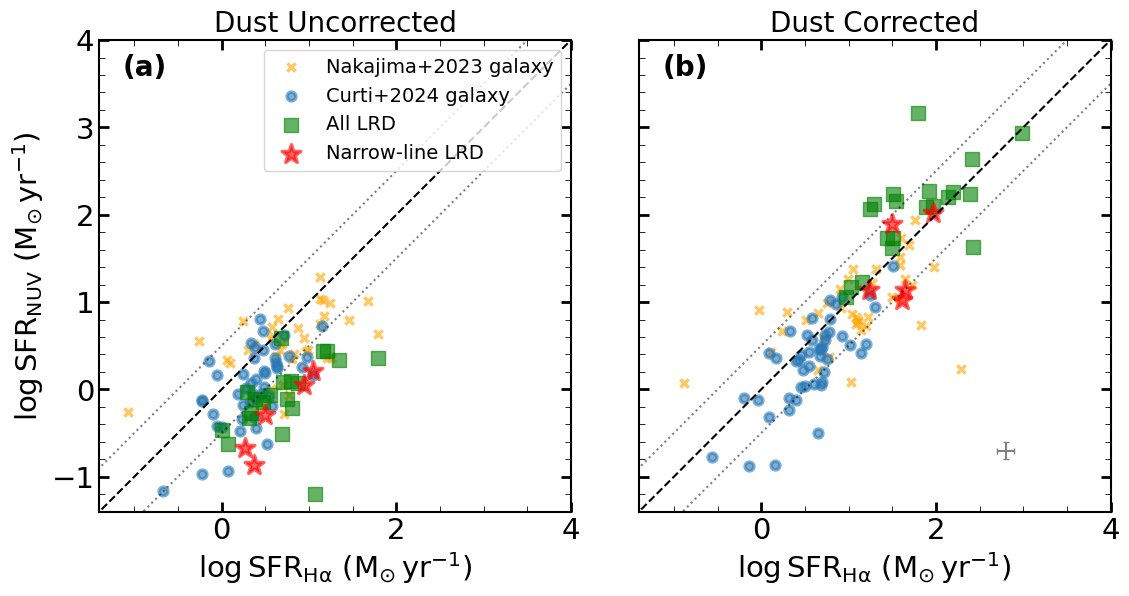

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# plt.style.use('seaborn-v0_8-colorblind')

#------------------------#
#      SFR计算函数      #
#------------------------#
def compute_logsfr(lum_ha, lum_ha_err, lum_nuv, lum_fuv, av=None, correct_dust=False):
    """计算 log(SFR) 和误差"""
    if correct_dust and av is not None:
        dust_factor = 10**(0.4 * av)
        lum_ha = lum_ha * dust_factor
        lum_ha_err = lum_ha_err * dust_factor
    else:
        dust_factor = 1.0

    logsfr = {
        'Ha': np.log10(lum_ha) - 41.27,
        'Ha_err': lum_ha_err / lum_ha / np.log(10),
        'NUV': np.log10(lum_nuv) - 43.17,
        'FUV': np.log10(lum_fuv) - 43.35,
    }
    return logsfr

#------------------------#
#      数据准备阶段      #
#------------------------#
lrd_AV = lrd_spec_info['EBV'] * 3.16
jadegal_AV = jades_gal_info['EBV'] * 3.16
nakajimigal_AV = nakajimi_gal_info['EBV'] * 3.16

# LRD
sfr_lrd_na_uncorr = compute_logsfr(
    lrd_spec_info['Ha_Luminosity_narrow'],
    lrd_spec_info['Ha_Luminosity_err_narrow'],
    lrd_spec_info['L_NUV_att'],
    lrd_spec_info['L_FUV_att'],
    av=lrd_AV,
    correct_dust=False
)
sfr_lrd_na_corr = compute_logsfr(
    lrd_spec_info['Ha_Luminosity_narrow'],
    lrd_spec_info['Ha_Luminosity_err_narrow'],
    lrd_spec_info['L_NUV_unatt'],
    lrd_spec_info['L_FUV_unatt'],
    av=lrd_AV,
    correct_dust=True
)

sfr_lrd_total_uncorr = compute_logsfr(
    lrd_spec_info['Ha_Luminosity_narrow'] + lrd_spec_info['Ha_Luminosity_broad'],
    lrd_spec_info['Ha_Luminosity_err_narrow'],
    lrd_spec_info['L_NUV_att'],
    lrd_spec_info['L_FUV_att'],
    av=lrd_AV,
    correct_dust=False
)
sfr_lrd_total_corr = compute_logsfr(
    lrd_spec_info['Ha_Luminosity_narrow'] + lrd_spec_info['Ha_Luminosity_broad'],
    lrd_spec_info['Ha_Luminosity_err_narrow'],
    lrd_spec_info['L_NUV_unatt'],
    lrd_spec_info['L_FUV_unatt'],
    av=lrd_AV,
    correct_dust=True
)

sfr_lrd_na1_uncorr = compute_logsfr(
    lrd_spec_info['Ha_Luminosity_narrow_Ha1'],
    lrd_spec_info['Ha_Luminosity_err_narrow_Ha1'],
    lrd_spec_info['L_NUV_att'],
    lrd_spec_info['L_FUV_att'],
    av=lrd_AV,
    correct_dust=False
)
sfr_lrd_na1_corr = compute_logsfr(
    lrd_spec_info['Ha_Luminosity_narrow_Ha1'],
    lrd_spec_info['Ha_Luminosity_err_narrow_Ha1'],
    lrd_spec_info['L_NUV_unatt'],
    lrd_spec_info['L_FUV_unatt'],
    av=lrd_AV,
    correct_dust=True
)
# JADES
sfr_jade_uncorr = compute_logsfr(
    jades_gal_info['Ha_Luminosity'],
    jades_gal_info['Ha_Luminosity_err'],
    jades_gal_info['L_NUV_att'],
    jades_gal_info['L_FUV_att'],
    av=jadegal_AV,
    correct_dust=False
)
sfr_jade_corr = compute_logsfr(
    jades_gal_info['Ha_Luminosity'],
    jades_gal_info['Ha_Luminosity_err'],
    jades_gal_info['L_NUV_unatt'],
    jades_gal_info['L_FUV_unatt'],
    av=jadegal_AV,
    correct_dust=True
)

# Nakajimi
sfr_naka_uncorr = compute_logsfr(
    nakajimi_gal_info['Ha_Luminosity'],
    nakajimi_gal_info['Ha_Luminosity_err'],
    nakajimi_gal_info['L_NUV_att'],
    nakajimi_gal_info['L_FUV_att'],
    av=nakajimigal_AV,
    correct_dust=False
)
sfr_naka_corr = compute_logsfr(
    nakajimi_gal_info['Ha_Luminosity'],
    nakajimi_gal_info['Ha_Luminosity_err'],
    nakajimi_gal_info['L_NUV_unatt'],
    nakajimi_gal_info['L_FUV_unatt'],
    av=nakajimigal_AV,
    correct_dust=True
)

#------------------------#
#        绘图函数        #
#------------------------#


# ax2.scatter(Naka23z, Naka23zF150mag, c='orange', linewidths= 2.5, alpha = 0.6,marker='x', label=r'Nakajima+2023 galaxy',  s = 40)
# ax2.scatter(jadez, jadezF150mag, s=40,  linewidths= 2.5, c='#2878B5', alpha = 0.6, label=r'Curti+2024 galaxy')
# ax2.scatter(zmask, F150Wmask, s=40, alpha=0.6, marker='s', c='green', label='All LRDs')
# ax2.scatter(zmask[mask], F150Wmask[mask], facecolors='red', edgecolor='red', s=200, marker='*', linewidths= 2.5, alpha = 0.6, label=r'Narrow-line LRDs')
def plot_sfr_comparison(ax, sfr_lrd1, sfr_lrd2, sfr_jade, sfr_naka, narrow_mask, title, legendfont = None):
    ax.set_aspect('equal')
    
    ax.scatter(sfr_naka['Ha'], sfr_naka['NUV'], c='orange', linewidths= 2.5, alpha = 0.6,marker='x',label='Nakajima+2023 galaxy')
    ax.scatter(sfr_jade['Ha'], sfr_jade['NUV'], s=40,  linewidths= 2.5, c='#2878B5', alpha = 0.6,label='Curti+2024 galaxy')

    ax.scatter(sfr_lrd1['Ha'][~narrow_mask], sfr_lrd1['NUV'][~narrow_mask],s=100, alpha=0.6, marker='s', c='green', label='All LRD')
    ax.scatter(sfr_lrd2['Ha'][narrow_mask],  sfr_lrd2['NUV'][narrow_mask], facecolors='red', edgecolor='red', s=200, marker='*', linewidths= 2.5, alpha = 0.6, label='Narrow-line LRD')


    x = np.linspace(-2, 4, 100)
    ax.plot(x, x, 'k--')
    ax.plot(x, x - 0.5, 'k:', alpha=0.5)
    ax.plot(x, x + 0.5, 'k:', alpha=0.5)
    ax.set_xlim(-1.4, 4)
    ax.set_ylim(-1.4, 4)

    ax.set_title(title, fontsize=20)
    if legendfont:
        ax.legend(fontsize=legendfont, loc='upper right')

#------------------------#
#      绘制两个子图      #
#------------------------#
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

plot_sfr_comparison(axes[0], sfr_lrd_na_uncorr , sfr_lrd_na1_uncorr,  sfr_jade_uncorr, sfr_naka_uncorr, narrow_Ha_mask, 'Dust Uncorrected', legendfont=14)
plot_sfr_comparison(axes[1], sfr_lrd_na_corr , sfr_lrd_na1_corr, sfr_jade_corr, sfr_naka_corr, narrow_Ha_mask, 'Dust Corrected')

axes[0].text(0.05, 0.97, '(a)', transform=axes[0].transAxes, fontsize=20,verticalalignment='top',  weight='bold')
axes[1].text(0.05, 0.97, '(b)', transform=axes[1].transAxes, fontsize=20,verticalalignment='top',  weight='bold')
axes[0].set_ylabel(r'$\log \rm SFR_{\rm NUV} ~(M_{\odot} \, \rm yr^{-1})$')
axes[1].set_xlabel(r'$\log \rm SFR_{\rm H\alpha} ~(M_{\odot} \, \rm yr^{-1})$')
axes[0].set_xlabel(r'$\log \rm SFR_{\rm H\alpha} ~(M_{\odot} \, \rm yr^{-1})$')
# plot median error
median_error_x = np.median(sfr_lrd_na_uncorr['Ha_err'])
median_error_y = np.median(sfr_lrd_na_uncorr['Ha_err'])
axes[1].errorbar(2.8, -0.7, xerr=median_error_x, yerr=median_error_y,  fmt='none', ecolor='gray', capsize=2)


plt.tight_layout()
plt.savefig('/Users/zijianzhang/Astro_Data/LRD_SPEC/Figure/UV_Ha_SFR_compare.pdf', dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'plot_sfr_comparison' is not defined

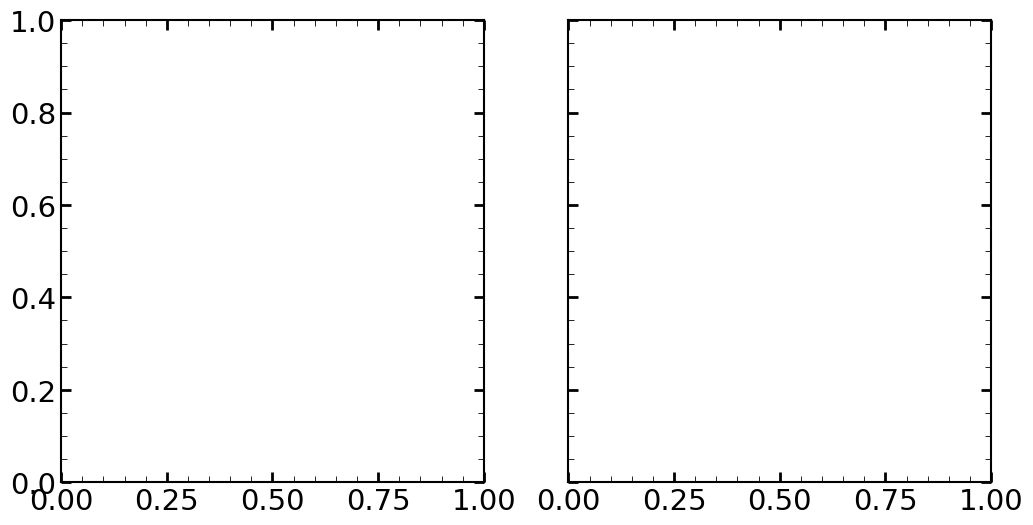

In [10]:
#------------------------#
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

plot_sfr_comparison(axes[0], sfr_lrd_total_uncorr , sfr_lrd_na1_uncorr,  sfr_jade_uncorr, sfr_naka_uncorr, narrow_Ha_mask, 'Dust Uncorrected', legendfont=14)
plot_sfr_comparison(axes[1], sfr_lrd_total_corr , sfr_lrd_na1_corr, sfr_jade_corr, sfr_naka_corr, narrow_Ha_mask, 'Dust Corrected')

axes[0].set_ylabel(r'$\log \rm SFR_{\rm NUV} ~[M_{\odot} \, \rm yr^{-1}]$')
axes[1].set_xlabel(r'$\log \rm SFR_{\rm H\alpha} ~[M_{\odot} \, \rm yr^{-1}]$')
axes[0].set_xlabel(r'$\log \rm SFR_{\rm H\alpha} ~[M_{\odot} \, \rm yr^{-1}]$')
plt.tight_layout()
plt.show()

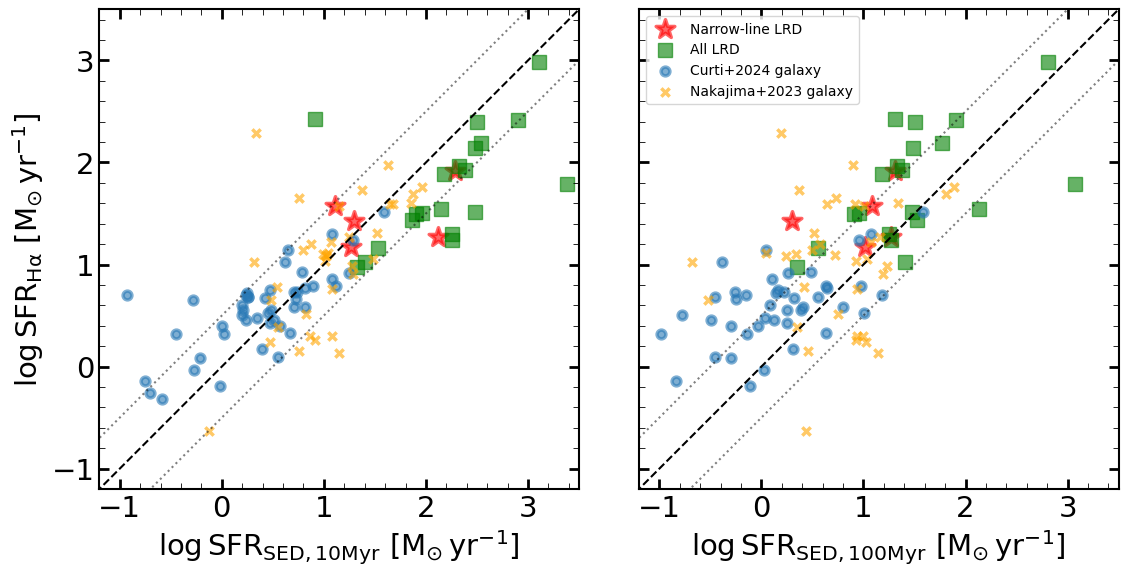

In [327]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)


x = np.linspace(-2, 4, 100)
axes[0].plot(x, x, 'k--')
axes[0].plot(x, x - 0.5, 'k:', alpha=0.5)
axes[0].plot(x, x + 0.5, 'k:', alpha=0.5)
axes[0].set_xlim(-1.2, 3.5)
axes[0].set_ylim(-1.2, 3.5)

axes[0].set_aspect('equal')
axes[0].scatter(np.log10(lrd_spec_info['sedsfr10'][narrow_Ha_mask]), sfr_lrd_na_corr['Ha'][narrow_Ha_mask],facecolors='red', edgecolor='red', s=200, marker='*', linewidths= 2.5, alpha = 0.6, label='Narrow-line LRD')
axes[0].scatter(np.log10(lrd_spec_info['sedsfr10'][~narrow_Ha_mask]), sfr_lrd_na_corr['Ha'][~narrow_Ha_mask], s=100, alpha=0.6, marker='s', c='green', label='All LRD')

#jade galaxy
axes[0].scatter(np.log10(jades_gal_info['sedsfr10']), sfr_jade_corr['Ha'] ,s=40,  linewidths= 2.5, c='#2878B5', alpha = 0.6,label='Curti+2024 galaxy')
axes[0].scatter(np.log10(nakajimi_gal_info['sedsfr10']), sfr_naka_corr['Ha'], c='orange',linewidths= 2.5, alpha = 0.6,marker='x',label='Nakajima+2023 galaxy')

axes[0].set_xlabel(r'$\log \rm SFR_{\rm SED,10Myr} ~[M_{\odot} \, \rm yr^{-1}]$')
axes[0].set_ylabel(r'$\log \rm SFR_{\rm H\alpha} ~[M_{\odot} \, \rm yr^{-1}]$')

axes[1].plot(x, x, 'k--')
axes[1].plot(x, x - 0.5, 'k:', alpha=0.5)
axes[1].plot(x, x + 0.5, 'k:', alpha=0.5)
axes[1].set_xlim(-1.2, 3.5)
axes[1].set_ylim(-1.2, 3.5)
axes[1].set_aspect('equal')
axes[1].scatter(np.log10(lrd_spec_info['sedsfr100'][narrow_Ha_mask]), sfr_lrd_na_corr['Ha'][narrow_Ha_mask],facecolors='red', edgecolor='red', s=200, marker='*', linewidths= 2.5, alpha = 0.6, label='Narrow-line LRD')
axes[1].scatter(np.log10(lrd_spec_info['sedsfr100'][~narrow_Ha_mask]), sfr_lrd_na_corr['Ha'][~narrow_Ha_mask], s=100, alpha=0.6, marker='s', c='green', label='All LRD')
axes[1].scatter(np.log10(jades_gal_info['sedsfr100']), sfr_jade_corr['Ha'] ,s=40,  linewidths= 2.5, c='#2878B5', alpha = 0.6,label='Curti+2024 galaxy')
axes[1].scatter(np.log10(nakajimi_gal_info['sedsfr100']), sfr_naka_corr['Ha'], c='orange',linewidths= 2.5, alpha = 0.6,marker='x',label='Nakajima+2023 galaxy')

axes[1].set_xlabel(r'$\log \rm SFR_{\rm SED,100Myr} ~[M_{\odot} \, \rm yr^{-1}]$')
plt.legend(fontsize = 10)
plt.tight_layout()
# axes[0].set_ylabel(r'$\log \rm SFR_{\rm H\alpha} ~[M_{\odot} \, \rm yr^{-1}]$')

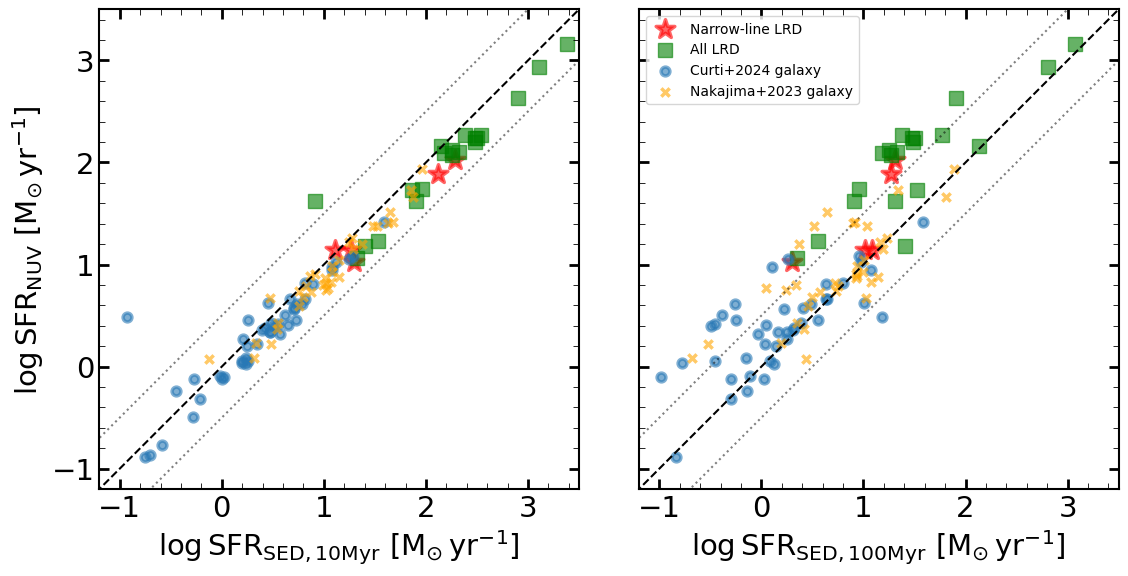

In [328]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)


x = np.linspace(-2, 4, 100)
axes[0].plot(x, x, 'k--')
axes[0].plot(x, x - 0.5, 'k:', alpha=0.5)
axes[0].plot(x, x + 0.5, 'k:', alpha=0.5)
axes[0].set_xlim(-1.2, 3.5)
axes[0].set_ylim(-1.2, 3.5)

axes[0].set_aspect('equal')
axes[0].scatter(np.log10(lrd_spec_info['sedsfr10'][narrow_Ha_mask]), sfr_lrd_na_corr['NUV'][narrow_Ha_mask],facecolors='red', edgecolor='red', s=200, marker='*', linewidths= 2.5, alpha = 0.6, label='Narrow-line LRD')
axes[0].scatter(np.log10(lrd_spec_info['sedsfr10'][~narrow_Ha_mask]), sfr_lrd_na_corr['NUV'][~narrow_Ha_mask], s=100, alpha=0.6, marker='s', c='green', label='All LRD')

#jade galaxy
axes[0].scatter(np.log10(jades_gal_info['sedsfr10']), sfr_jade_corr['NUV'] ,s=40,  linewidths= 2.5, c='#2878B5', alpha = 0.6,label='Curti+2024 galaxy')
axes[0].scatter(np.log10(nakajimi_gal_info['sedsfr10']), sfr_naka_corr['NUV'], c='orange',linewidths= 2.5, alpha = 0.6,marker='x',label='Nakajima+2023 galaxy')

axes[0].set_xlabel(r'$\log \rm SFR_{\rm SED,10Myr} ~[M_{\odot} \, \rm yr^{-1}]$')
axes[0].set_ylabel(r'$\log \rm SFR_{\rm NUV} ~[M_{\odot} \, \rm yr^{-1}]$')

axes[1].plot(x, x, 'k--')
axes[1].plot(x, x - 0.5, 'k:', alpha=0.5)
axes[1].plot(x, x + 0.5, 'k:', alpha=0.5)
axes[1].set_xlim(-1.2, 3.5)
axes[1].set_ylim(-1.2, 3.5)
axes[1].set_aspect('equal')
axes[1].scatter(np.log10(lrd_spec_info['sedsfr100'][narrow_Ha_mask]), sfr_lrd_na_corr['NUV'][narrow_Ha_mask],facecolors='red', edgecolor='red', s=200, marker='*', linewidths= 2.5, alpha = 0.6, label='Narrow-line LRD')
axes[1].scatter(np.log10(lrd_spec_info['sedsfr100'][~narrow_Ha_mask]), sfr_lrd_na_corr['NUV'][~narrow_Ha_mask], s=100, alpha=0.6, marker='s', c='green', label='All LRD')
axes[1].scatter(np.log10(jades_gal_info['sedsfr100']), sfr_jade_corr['NUV'] ,s=40,  linewidths= 2.5, c='#2878B5', alpha = 0.6,label='Curti+2024 galaxy')
axes[1].scatter(np.log10(nakajimi_gal_info['sedsfr100']), sfr_naka_corr['NUV'], c='orange',linewidths= 2.5, alpha = 0.6,marker='x',label='Nakajima+2023 galaxy')

axes[1].set_xlabel(r'$\log \rm SFR_{\rm SED,100Myr} ~[M_{\odot} \, \rm yr^{-1}]$')
plt.legend(fontsize = 10)
plt.tight_layout()
# axes[0].set_ylabel(r'$\log \rm SFR_{\rm H\alpha} ~[M_{\odot} \, \rm yr^{-1}]$')

In [329]:
jades_gal_info


source_id,grating,BIC_Ha1,AIC_Ha1,reduced_chi2_Ha1,Ha_EW_narrow_Ha1,Ha_EW_narrow_err_Ha1,OIII_FWHM,OIII_EW,OIII_Luminosity,Hb_FWHM,Hb_EW,Hb_Luminosity,Hb_Luminosity_err,Ha_FWHM,Ha_FWHM_err,Ha_intrinsic_FWHM,Ha_intrinsic_FWHM_err,Ha_Luminosity,Ha_Luminosity_err,OIII_FWHM_err,OIII_intrinsic_FWHM,OIII_intrinsic_FWHM_err,OIII_EW_err,OIII_Luminosity_err,Hb_FWHM_err,Hb_intrinsic_FWHM,Hb_intrinsic_FWHM_err,Hb_EW_err,L_NUV_att,L_FUV_att,L_NUV_unatt,L_FUV_unatt,EBV,sedsfr10,sedsfr100
int64,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
7301,g395h-f290lp2,168.361,155.865,2.47,156.42,10.11,166.49,656.87,3.842e+42,175.25,178.3,6.802e+41,3.267e+40,156.42,2.6,140.49,61.81,2.076e+42,6.028e+40,2.26,139.84,75.92,8.09,9.577e+40,4.84,157.17,69.67,2.28,2.1466741766834574e+43,3.886405987630056e+43,3.818565734074258e+43,8.022212300971703e+43,0.07513638267502888,4.479417885471944,1.1185641107173945
7302,g395m-f290lp3,48.972,40.213,1.734,227.58,7.46,282.67,801.54,3.324e+42,249.95,103.06,6.131e+41,5.353e+40,227.58,5.85,149.35,112.76,1.773e+42,7.798e+40,4.31,175.06,137.47,9.84,8.818e+40,13.09,148.69,119.77,1.3,3.4810286213547254e+43,6.679426034320201e+43,4.746673144580051e+43,9.206232567245923e+43,0.03439658670914017,4.139416186734409,0.41480718296911867
7304,g395h-f290lp1,97.16,86.181,2.045,150.1,0.99,307.94,104.11,3.255e+41,--,--,--,--,150.1,19.24,113.36,75.71,1.347e+41,2.9e+40,24.75,221.15,154.92,1.27,4.42e+40,--,--,--,--,3.1476933424443036e+43,3.570900305313264e+43,6.847384381350598e+43,1.2088874800708361e+44,0.36878860768941885,4.655876856794671,4.306224321730393
7308,g395h-f290lp1,130.878,120.149,2.933,184.0,3.27,214.82,353.69,1.308e+42,252.32,61.11,2.134e+41,2.215e+40,184.0,7.52,152.25,85.72,5.531e+41,4.446e+40,4.05,--,--,4.4,4.502e+40,15.33,151.5,121.5,0.77,4.195410575641584e+43,5.579177617479545e+43,9.58448744907114e+43,1.7383190951722129e+44,0.2481662403177764,7.8243678339478375,4.341485670666326
7309,g395h-f290lp2,185.556,174.373,4.09,173.62,3.74,289.01,387.37,6.972e+41,228.86,85.7,1.959e+41,2.849e+40,173.62,7.71,145.56,79.6,4.325e+41,3.322e+40,9.65,201.21,144.59,4.75,4.271e+40,19.7,140.72,111.64,1.09,3.3743524319825627e+43,5.046598720080035e+43,4.2418888962411294e+43,6.835296764455111e+43,0.2503527221932515,1.7934387840996355,3.5645689358654904
7310,g395h-f290lp1,175.999,163.724,2.732,170.59,2.64,169.19,455.75,2.136e+42,214.07,63.53,3.294e+41,5.941e+40,170.59,6.43,154.66,65.51,9.698e+41,6.188e+40,3.2,140.03,78.63,5.74,6.993e+40,23.28,198.26,77.82,0.81,6.214095640937151e+43,8.675870162825295e+43,1.4013724449114662e+44,2.492427815069342e+44,0.10861066164690615,12.039122318849437,1.270717670768416
7311,g235m-f170lp1,65.29,56.532,2.221,249.84,5.57,279.46,1518997787200.18,2.422e+41,--,--,--,--,249.84,26.72,175.11,126.3,1.475e+41,2.628e+40,22.09,129.99,115.53,18631308863.09,3.293e+40,--,--,--,--,7.699178290289598e+42,1.0808733049310923e+43,3.838038512547159e+43,7.735921576706551e+43,0.1535271355005235,3.5251317604298444,0.35251317604459487
7313,g395m-f290lp2,75.964,67.392,2.741,295.34,1.8,275.28,127.63,7.317e+41,--,--,--,--,295.34,21.84,233.45,144.04,4.502e+41,5.617e+40,11.73,150.59,126.22,1.57,5.36e+40,--,--,--,--,4.530758845651781e+43,6.095146020249808e+43,4.535352615671266e+43,6.103087980024865e+43,0.2510248533828469,0.11726387135111765,15.247732242568286
7314,g395m-f290lp1,61.3,52.792,2.202,220.85,5.15,269.36,401.59,7.626e+41,--,--,--,--,220.85,14.3,125.83,103.73,4.059e+41,4.439e+40,9.65,135.17,117.02,4.94,4.588e+40,--,--,--,--,5.052571219739262e+43,6.364778070864814e+43,6.206275032651063e+43,8.710203714383987e+43,0.15116899594522076,2.8158888582994352,10.140249056456751


In [369]:
jades_gal_bagpipe = Table.read('/Users/zijianzhang/Astro_Data/LRD_SPEC/Code/pipes/cats/jades_galaxy.fits')
jades_gal_bagpipe

sfrlist = []

for i in range(len(jades_NIRspec_ID)):
    try:
        idx = np.where(jades_gal_bagpipe['#ID'].value.astype(int) == (jades_NIRspec_ID[i]))[0][0]
        sfrlist.append(jades_gal_bagpipe['sfr_50'][idx])
    except:
        sfrlist.append(np.nan)

Text(0, 0.5, '$\\log \\rm SFR_{\\rm NUV} ~[M_{\\odot} \\, \\rm yr^{-1}]$')

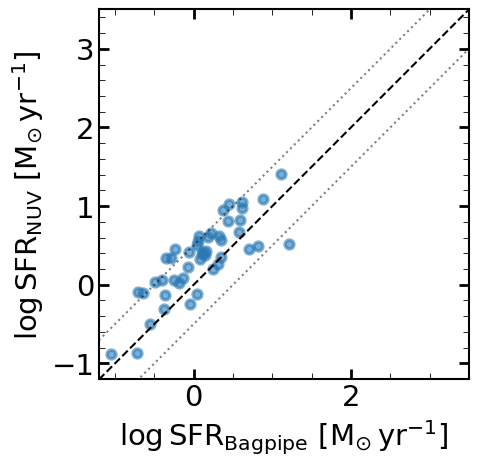

In [376]:
plt.gca().set_aspect('equal')
plt.scatter(np.log10(sfrlist), sfr_jade_corr['NUV'] ,s=40,  linewidths= 2.5, c='#2878B5', alpha = 0.6,label='Curti+2024 galaxy')
plt.plot(x, x, 'k--')
plt.plot(x, x - 0.5, 'k:', alpha=0.5)
plt.plot(x, x + 0.5, 'k:', alpha=0.5)
plt.xlim(-1.2, 3.5)
plt.ylim(-1.2, 3.5)

plt.xlabel(r'$\log \rm SFR_{\rm Bagpipe} ~[M_{\odot} \, \rm yr^{-1}]$')
plt.ylabel(r'$\log \rm SFR_{\rm NUV} ~[M_{\odot} \, \rm yr^{-1}]$')

Text(0, 0.5, '$\\log \\rm SFR_{\\rm H\\alpha} ~[M_{\\odot} \\, \\rm yr^{-1}]$')

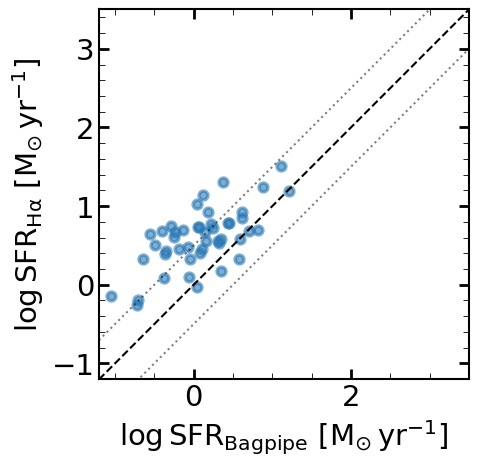

In [377]:
plt.gca().set_aspect('equal')
plt.scatter(np.log10(sfrlist), sfr_jade_corr['Ha'] ,s=40,  linewidths= 2.5, c='#2878B5', alpha = 0.6,label='Curti+2024 galaxy')
plt.plot(x, x, 'k--')
plt.plot(x, x - 0.5, 'k:', alpha=0.5)
plt.plot(x, x + 0.5, 'k:', alpha=0.5)
plt.xlim(-1.2, 3.5)
plt.ylim(-1.2, 3.5)

plt.xlabel(r'$\log \rm SFR_{\rm Bagpipe} ~[M_{\odot} \, \rm yr^{-1}]$')
plt.ylabel(r'$\log \rm SFR_{\rm H\alpha} ~[M_{\odot} \, \rm yr^{-1}]$')

In [337]:
selected_tab

#ID,burst:age_16,burst:age_50,burst:age_84,burst:massformed_16,burst:massformed_50,burst:massformed_84,calib:0_16,calib:0_50,calib:0_84,calib:1_16,calib:1_50,calib:1_84,calib:2_16,calib:2_50,calib:2_84,delayed:age_16,delayed:age_50,delayed:age_84,delayed:massformed_16,delayed:massformed_50,delayed:massformed_84,delayed:metallicity_16,delayed:metallicity_50,delayed:metallicity_84,delayed:tau_16,delayed:tau_50,delayed:tau_84,dust:Av_16,dust:Av_50,dust:Av_84,dust:eta_16,dust:eta_50,dust:eta_84,nebular:logU_16,nebular:logU_50,nebular:logU_84,noise:scaling_16,noise:scaling_50,noise:scaling_84,veldisp_16,veldisp_50,veldisp_84,stellar_mass_16,stellar_mass_50,stellar_mass_84,formed_mass_16,formed_mass_50,formed_mass_84,sfr_16,sfr_50,sfr_84,ssfr_16,ssfr_50,ssfr_84,nsfr_16,nsfr_50,nsfr_84,mass_weighted_age_16,mass_weighted_age_50,mass_weighted_age_84,tform_16,tform_50,tform_84,tquench_16,tquench_50,tquench_84,input_redshift,log_evidence,log_evidence_err
bytes8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2923,0.00044030015867031356,0.001332148226165335,0.004335658385193502,4.498596858685721,5.16139176795242,5.67750094439386,0.6987524372136864,0.7158668343223448,0.7345051546440806,-0.14536406537471394,-0.1219019165632186,-0.09627880249994994,-0.07565503765375431,-0.05743553675144965,-0.03898455595050865,0.10117707206545731,0.10439832573266054,0.11197764845782457,7.602808968211932,7.619202031182814,7.6384587771657975,0.12064051474107966,0.12674881179181585,0.13044045300552798,0.9278250545843074,1.38394358961878,1.8236848575211524,0.1344801056087187,0.15430708165768675,0.1734243169260462,1.03468221202078,1.126049182301455,1.3122563548780393,-0.6032796074774743,-0.5102611296589394,-0.40939997783228244,1.1607885657604662,1.1863826608738486,1.2176616361035917,254.00273573426358,325.16077843103415,408.0390358091586,7.520108055042686,7.535669871513008,7.555961497543415,7.604589168823042,7.620806272899664,7.6423104846979895,0.40273596693148744,0.4170539272570225,0.43405837410217707,-7.917944275013485,-7.915267966642379,-7.914748093424685,1.318076239423786,1.3227226608181648,1.323552926127482,0.03408937765407314,0.03516731072198198,0.03766337373969288,2.0631810791910925,2.0656771422088034,2.066755075276712,99.0,99.0,99.0,3.015,487.5518880288013,0.009463864771517807
21150,0.007417140968508222,0.007848771462586572,0.008335973009404167,8.370246786272345,8.3720186075841,8.372917032801926,1.4635751678251967,1.4678789234697214,1.469559245679806,-0.4694687310465217,-0.4666942659606901,-0.4640428419874307,-0.3894779270818107,-0.38626558887681267,-0.38293216096002547,0.6155948830375556,0.6230760709997694,0.6291348202238175,8.770384995602699,8.775418883816087,8.780683220982962,0.19239192795707008,0.19551527879939545,0.19821815514621757,1.2301772256260886,1.293583520748233,1.341688105421001,0.1085798274240315,0.10930368327412929,0.10988366587524324,1.1441688095879687,1.150607897802562,1.1566081508809982,-2.5820547444212987,-2.5713994670349334,-2.5597521260330334,9.993392864921113,9.99645136268299,9.998582164741768,66.8618290240501,76.87910571906657,87.59098699777863,8.793840495125083,8.796759413631385,8.79992212140658,8.916078326053675,8.919630403684229,8.923359726594517,3.8979500608721764,3.9048555465800865,3.9137772589516757,-8.208390219826025,-8.205164412271067,-8.201896637613698,0.978785250622926,0.9827195590646571,0.986628107783722,0.16072573574920734,0.1633997069469174,0.16599416283159912,1.8794578901193881,1.8820523460040697,1.8847263172017799,99.0,99.0